<a href="https://colab.research.google.com/github/wiktoriaszmidt/lecture1/blob/main/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model Predykcyjny Popularności Utworu:**

 Analiza Wpływu Popularności Artysty w Oparciu o Spotify Global Music Dataset (2009–2025)

**Cel**

Zbudowanie sieci neuronowej do przewidywania wskaźnika popularności utworu na platformie Spotify. Model analizuje, jak popularność artysty wpływa na potencjał rynkowy jego nowych utworów.

**Zastosowanie**

- Prognozowanie Sukcesu: Narzędzie dla artystów i menadżerów do oceny potencjału komercyjnego nowego utworu przed premierą.

- Optymalizacja Promocji: Wsparcie dla platform streamingowych (Spotify) w ulepszaniu algorytmów rekomendacyjnych i strategii marketingowych.

# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import issparse

# Funkcja Wizualizacyjna dla Historii Treningu (Regresja)

Definicja Funkcji Wizualizacyjnej

In [2]:
# Wybór pozostałych parametrów: Metryka Ewaluacyjna (MAE)
def Show_history(history, epochs, metric_name='mean_absolute_error'):
  """Wizualizacja historii treningu modelu regresji (Loss i MAE)"""
  metric = history.history[metric_name]
  val_metric = history.history[f'val_{metric_name}']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, metric, label=f"Training {metric_name.upper()}")
  plt.plot(epochs_range, val_metric, label=f"Validation {metric_name.upper()}")
  plt.legend(loc='upper right')
  plt.title(f'Training and Validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('MAE Value')

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="Training loss (MSE)")
  plt.plot(epochs_range, val_loss, label="Validation loss (MSE)")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Losses (MSE)")
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.show()

# Przygotowanie Danych (Wczytanie, Czyszczenie, Kodowanie, Skalowanie)

In [4]:
# Wczytanie danych (plik 'spotify_data clean.csv')
df = pd.read_csv('spotify_data clean.csv')

In [5]:
# Usunięcie zbędnych kolumn
df = df.drop(columns=['track_id', 'album_id', 'artist_genres'])

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_name          8582 non-null   object 
 1   track_number        8582 non-null   int64  
 2   track_popularity    8582 non-null   int64  
 3   explicit            8582 non-null   bool   
 4   artist_name         8579 non-null   object 
 5   artist_popularity   8582 non-null   int64  
 6   artist_followers    8582 non-null   int64  
 7   album_name          8582 non-null   object 
 8   album_release_date  8582 non-null   object 
 9   album_total_tracks  8582 non-null   int64  
 10  album_type          8582 non-null   object 
 11  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 746.0+ KB
None


In [9]:
print(df.describe())

       track_number  track_popularity  artist_popularity  artist_followers  \
count   8582.000000       8582.000000        8582.000000      8.582000e+03   
mean       5.772547         52.356211          69.730016      2.403472e+07   
std        6.052792         23.816076          19.645979      3.803180e+07   
min        1.000000          0.000000           0.000000      0.000000e+00   
25%        1.000000         39.000000          60.000000      4.623200e+05   
50%        4.000000         58.000000          74.000000      6.105547e+06   
75%        9.000000         71.000000          84.000000      2.725255e+07   
max      102.000000         99.000000         100.000000      1.455421e+08   

       album_total_tracks  track_duration_min  
count         8582.000000         8582.000000  
mean            13.789443            3.492805  
std             11.887131            1.057970  
min              1.000000            0.070000  
25%              6.000000            2.880000  
50%      

In [11]:
print("\n Weryfikacja Brakujących Wartości")
print(df.isnull().sum())
initial_length = len(df)
print(f"Początkowa liczba wierszy: {initial_length}")


 Weryfikacja Brakujących Wartości
track_name            0
track_number          0
track_popularity      0
explicit              0
artist_name           3
artist_popularity     0
artist_followers      0
album_name            0
album_release_date    0
album_total_tracks    0
album_type            0
track_duration_min    0
dtype: int64
Początkowa liczba wierszy: 8582


In [12]:
# Usunięcie brakujących wartości w 'artist_name'
df.dropna(subset=['artist_name'], inplace=True)
final_length = len(df)
print(f"Końcowa liczba wierszy po usunięciu NaN: {final_length}")

Końcowa liczba wierszy po usunięciu NaN: 8579


In [13]:
# Konwersja typów dla ColumnTransformer
df['explicit'] = df['explicit'].astype('category')
df['album_type'] = df['album_type'].astype('category')

#  Przetwarzanie Danych (Selekcja Cech i Skalowanie)

In [14]:
# Definicja cech X i celu y
X = df.drop(columns=['track_popularity', 'track_name', 'artist_name', 'album_name', 'album_release_date'])
y = df['track_popularity']

In [15]:
# Definicja typów cech
numerical_features = ['artist_popularity', 'artist_followers', 'track_number', 'album_total_tracks', 'track_duration_min']
categorical_features = ['explicit', 'album_type']

In [16]:
# Zakodowanie danych kategorialnych (OneHotEncoder) i Skalowanie (StandardScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

In [17]:
# Podział zbioru danych na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Przetwarzanie i Skalowanie
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
# Konwersja na tablicę NumPy dla TensorFlow
if issparse(X_train_transformed):
    X_train_processed = X_train_transformed.toarray()
else:
    X_train_processed = X_train_transformed

if issparse(X_test_transformed):
    X_test_processed = X_test_transformed.toarray()
else:
    X_test_processed = X_test_transformed

input_shape = X_train_processed.shape[1]
print(f"\nLiczba cech wejściowych po przetworzeniu: {input_shape}")


Liczba cech wejściowych po przetworzeniu: 10


# Trening Sieci Neuronowej i Poprawa (Historia Zmian)

#### Iteracja 1: Model Bazowy (V1) - Ustalenie Baseline

In [19]:
# Budowa sieci neuronowej: Wybór rodzaju i liczby warstw ukrytych oraz neuronów
model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
# Warstwa 1: Wybór liczby neuronów (32) i funkcji aktywacji (relu)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
# Warstwa 2
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
# Warstwa wyjściowa: 1 neuron, Wybór funkcji aktywacji (Liniowa - dla regresji)
    tf.keras.layers.Dense(1)
])

Konfiguracja sieci neuronowej: Wybór algorytmu optymalizującego (Adam)

Wybór funkcji kosztu (MSE)

In [20]:
# Konfiguracja Sieci Neuronowej V1
model_v1.compile(optimizer='adam',
                 loss='mean_squared_error',
                 metrics=['mean_absolute_error'])

print("\nModel V1 Summary:")
model_v1.summary()


Model V1 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)


MAE Modelu V1 (50 epok): 15.2486


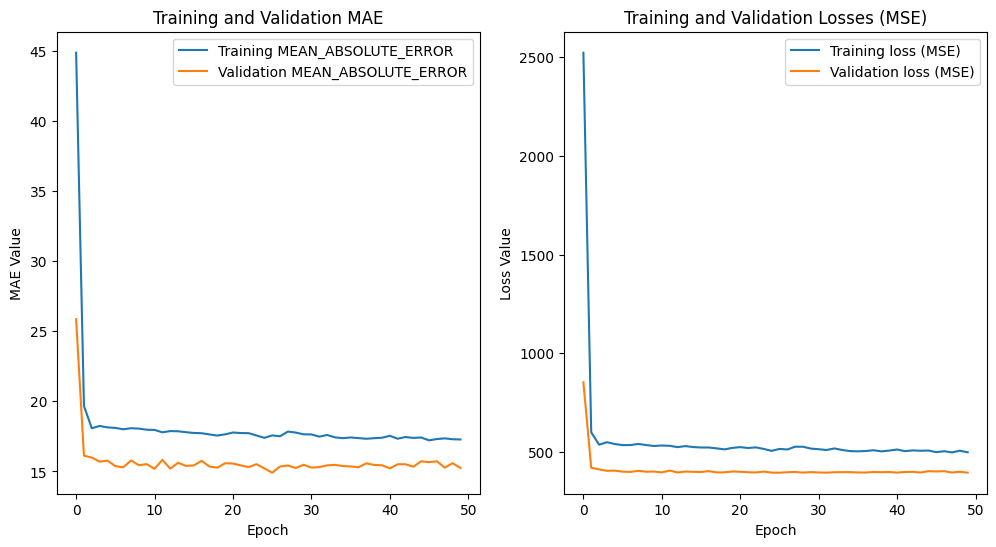

--------------------------------------------------


In [21]:
# Trening Modelu V1
history_v1 = model_v1.fit(
    X_train_processed,
    y_train,
    epochs=50,
    validation_data=(X_test_processed, y_test),
    batch_size=32,
    verbose=0
)

loss_v1, mae_v1 = model_v1.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nMAE Modelu V1 (50 epok): {mae_v1:.4f}")

Show_history(history_v1, 50)
print("-" * 50)

#### Iteracja 2: Poprawa Skuteczności (V2) - Zwiększenie Pojemności

In [22]:
# Wybór pozostałych parametrów: Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [23]:
# Poprawa sieci neuronowej: Zmiana struktury warstw i neuronów (128 -> 64 -> 32)
model_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [24]:
# Konfiguracja Sieci Neuronowej V2
model_v2.compile(optimizer='adam',
                 loss='mean_squared_error',
                 metrics=['mean_absolute_error'])

print("\nModel V2 Summary (Poprawiony):")
model_v2.summary()

# Trening V2: Ustawienie dużej wartości epochs, kontrolowanej przez EarlyStopping
history_v2 = model_v2.fit(
    X_train_processed,
    y_train,
    epochs=300,
    validation_data=(X_test_processed, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)


Model V2 Summary (Poprawiony):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 20.



Najlepsze MAE Modelu V2: 14.5113


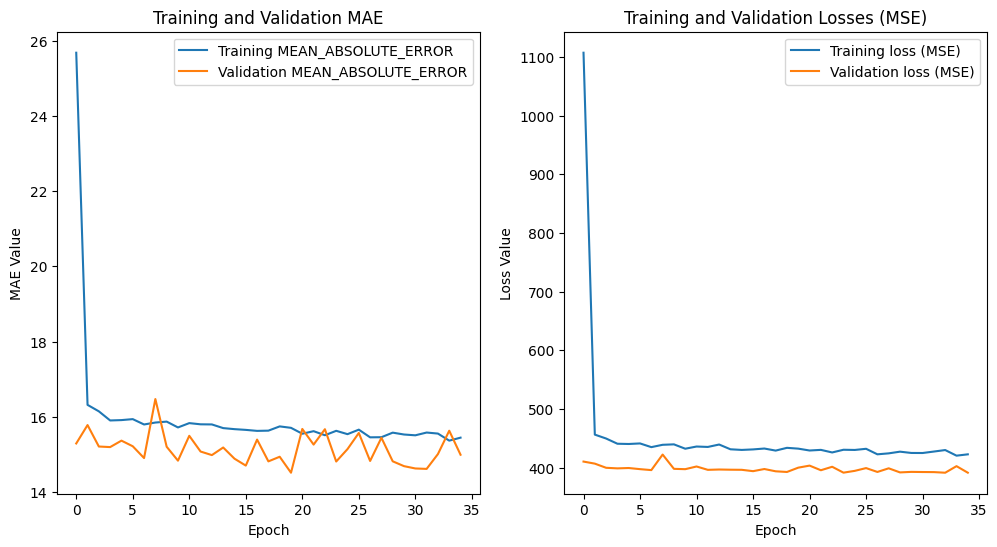

--------------------------------------------------


In [25]:
# Ewaluacja
loss_v2, mae_v2 = model_v2.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nNajlepsze MAE Modelu V2: {mae_v2:.4f}")

Show_history(history_v2, len(history_v2.history['loss']))
print("-" * 50)

#### Iteracja 3: Doszkolenie (V3) - Precyzyjna Regularyzacja

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

input_shape = X_train_processed.shape[1]

In [32]:
# Poprawa sieci neuronowej: Dostrojenie Learning Rate i Regularyzacja L2
early_stopping_v3 = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=20, # Zwiększona cierpliwość
    restore_best_weights=True,
    verbose=1
)

In [33]:
# Niższy Learning Rate
opt_v3 = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [34]:
model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    # Regularyzacja L2 w warstwach ukrytych
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1) # Warstwa wyjściowa
])

In [35]:
# Konfiguracja: Użycie dostrojonego optymalizatora opt_v3
model_v3.compile(optimizer=opt_v3,
                 loss='mean_squared_error',
                 metrics=['mean_absolute_error'])

print("\nModel V3 Summary:")
model_v3.summary()


Model V3 Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Trening Modelu V3
history_v3 = model_v3.fit(
    X_train_processed,
    y_train,
    epochs=300,
    validation_data=(X_test_processed, y_test),
    batch_size=32,
    callbacks=[early_stopping_v3]
)

Epoch 1/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 2268.7539 - mean_absolute_error: 41.0392 - val_loss: 447.1583 - val_mean_absolute_error: 16.3228
Epoch 2/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 483.7937 - mean_absolute_error: 16.9650 - val_loss: 411.7699 - val_mean_absolute_error: 15.7667
Epoch 3/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 456.5808 - mean_absolute_error: 16.3481 - val_loss: 400.4777 - val_mean_absolute_error: 15.1763
Epoch 4/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 458.0767 - mean_absolute_error: 16.3368 - val_loss: 399.4631 - val_mean_absolute_error: 15.1763
Epoch 5/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 445.8326 - mean_absolute_error: 15.8988 - val_loss: 403.5063 - val_mean_absolute_error: 15.5452
Epoch 6/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 439.7929 - mean_absolute_error: 15.9179 - val_loss: 396.8112 - val_mean_absolute_error: 15.1598
Epoch 7/300
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 


Najlepsze MAE Modelu V3: 14.5663


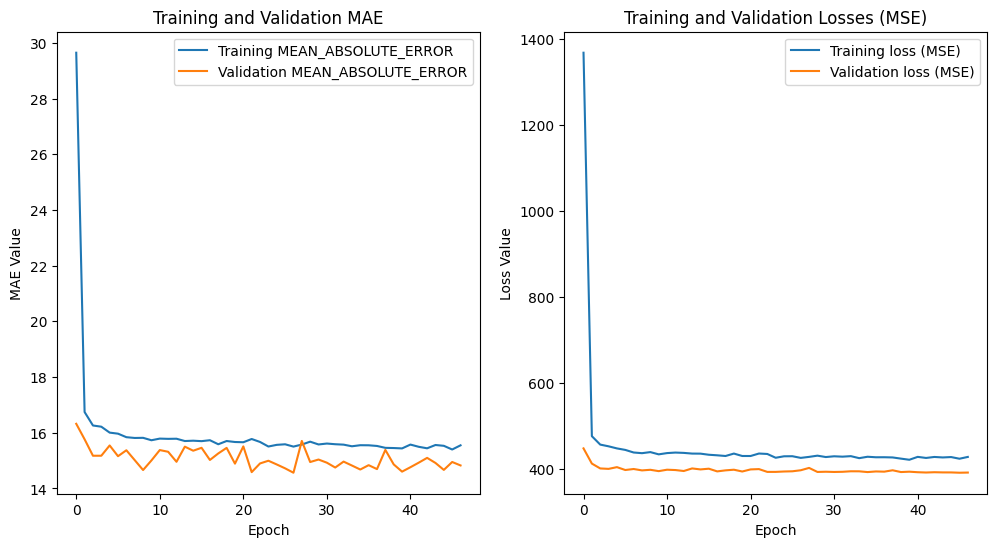

--------------------------------------------------


In [37]:
# Ewaluacja
loss_v3, mae_v3 = model_v3.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nNajlepsze MAE Modelu V3: {mae_v3:.4f}")

Show_history(history_v3, len(history_v3.history['loss']))
print("-" * 50)

# Ilustracja Działania Sieci i Jej Ewaluacja

In [26]:
# 1. Predykcja dla danych spoza zbioru testowego (losowa próbka)
random_input = np.zeros((1, input_shape))

predicted_popularity = model_v2.predict(random_input)

print("\n--- Predykcja dla Próbki Losowej (Uśrednione cechy) ---")
print(f"Przewidywana popularność: {predicted_popularity[0][0]:.2f} / 100")
print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step

--- Predykcja dla Próbki Losowej (Uśrednione cechy) ---
Przewidywana popularność: 21.77 / 100
--------------------------------------------------


In [27]:
# 2. Predykcja na zbiorze testowym
y_pred_final = model_v2.predict(X_test_processed).flatten()

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


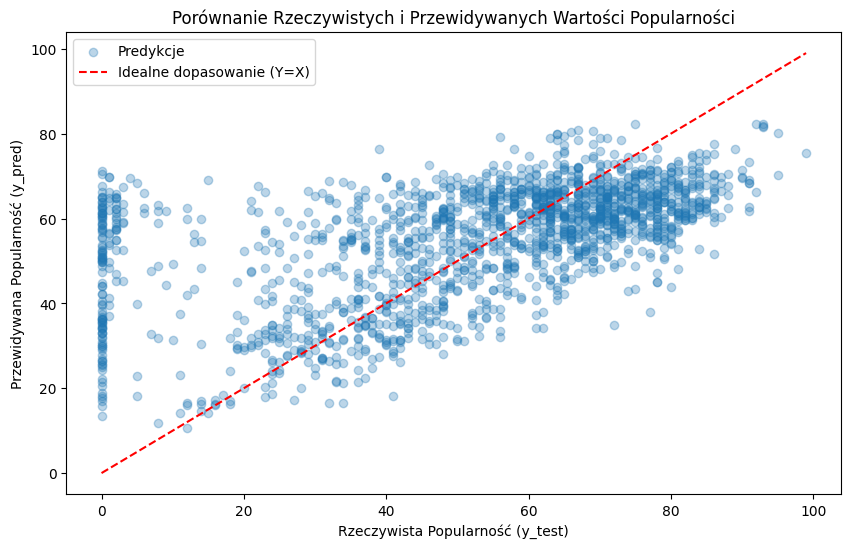

In [28]:
# 3. Wykres Porównujący Wartości (dla prognozowania/regresji)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3, label="Predykcje")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Idealne dopasowanie (Y=X)")
plt.xlabel("Rzeczywista Popularność (y_test)")
plt.ylabel("Przewidywana Popularność (y_pred)")
plt.title("Porównanie Rzeczywistych i Przewidywanych Wartości Popularności")
plt.legend()
plt.show()

In [29]:
# 4. Wygenerowanie Raportu z Metrykami
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n--- Ostateczny Raport Metryk Działania Modelu V2 ---")
print(f"1. Mean Absolute Error (MAE): {mae_final:.4f}")
print(f"2. Mean Squared Error (MSE): {mse_final:.4f}")
print(f"3. Współczynnik Determinacji (R²): {r2_final:.4f}")


--- Ostateczny Raport Metryk Działania Modelu V2 ---
1. Mean Absolute Error (MAE): 14.5113
2. Mean Squared Error (MSE): 399.9452
3. Współczynnik Determinacji (R²): 0.2934


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Ostateczny Raport Metryk Działania Modelu V3 ---
1. Mean Absolute Error (MAE): 14.5663
2. Mean Squared Error (MSE): 396.0452
3. Współczynnik Determinacji (R²): 0.3003
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


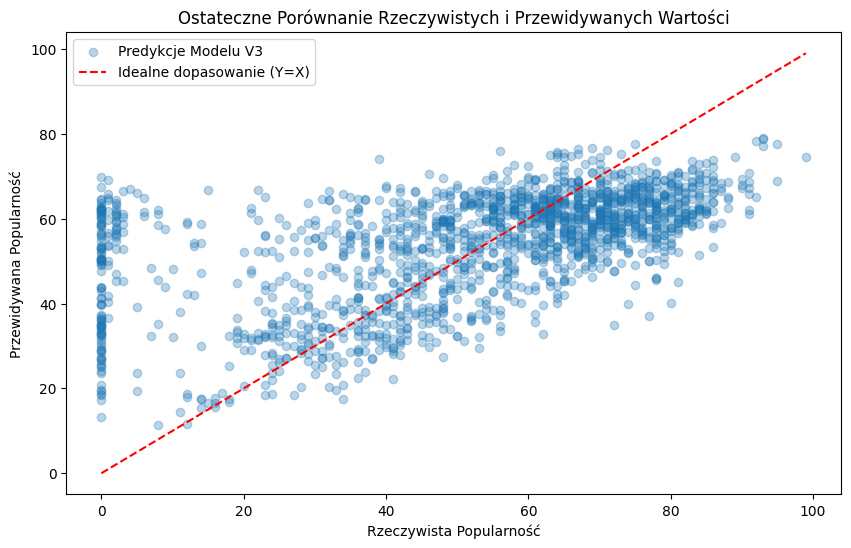

In [38]:


# Obliczenie metryk dla Modelu V3
mse_final = mean_squared_error(y_test, model_v3.predict(X_test_processed).flatten())
mae_final = mean_absolute_error(y_test, model_v3.predict(X_test_processed).flatten())
r2_final = r2_score(y_test, model_v3.predict(X_test_processed).flatten())

print("\n--- Ostateczny Raport Metryk Działania Modelu V3 ---")
print(f"1. Mean Absolute Error (MAE): {mae_final:.4f}")
print(f"2. Mean Squared Error (MSE): {mse_final:.4f}")
print(f"3. Współczynnik Determinacji (R²): {r2_final:.4f}")

# Wygenerowanie wykresu porównawczego
y_pred_final = model_v3.predict(X_test_processed).flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3, label="Predykcje Modelu V3")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Idealne dopasowanie (Y=X)")
plt.xlabel("Rzeczywista Popularność")
plt.ylabel("Przewidywana Popularność")
plt.title("Ostateczne Porównanie Rzeczywistych i Przewidywanych Wartości")
plt.legend()
plt.show()